In [1]:
# pip install torch torchvision
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.utils as vutils
import torch.nn as nn
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from loss_functions import CombinedLoss
from discriminator_model import DiscriminatorModel
from upscaling_model import UpscalingModel
from data_sets_loaders import get_train_val_test_dataloaders
import os

%matplotlib inline

In [2]:
def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    plt.imshow(np.transpose(vutils.make_grid(x[:4].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()


loss_a = 2.0
loss_p = 1.0
loss_f = 2.0
loss_t = 0.3
loss_c = 4.0


def get_model_filename(epoch, model):
    return f"prototype_cost_models_temp/model_{loss_a}_{loss_p}_{loss_f}_{loss_t}_{loss_c}_{epoch}_{model}.pth"


def train_prototype(train_dl, val_dl, num_epochs=5, learning_rate=1e-4):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    discriminator_model = DiscriminatorModel(3, 8, 0.3).to(device)
    upscaling_model = UpscalingModel(3, 3, 3, 32, 10).to(device)

    discriminator_params = torch.cat([x.view(-1) for x in discriminator_model.parameters()])

    upscaling_model.to(device)
    discriminator_model.to(device)
    upscaling_model.train()
    discriminator_model.train()

    torch.manual_seed(42)
    criterion = CombinedLoss(0.0, loss_p, loss_f, 0.0, loss_c, device=device)
    optimizer_upscale = torch.optim.Adam(upscaling_model.parameters(), lr=learning_rate) 
    optimizer_discriminator = torch.optim.Adam(discriminator_model.parameters(), lr=learning_rate) 
    
    iters, train_losses, val_losses = [], [], []
    n = 0
    for epoch in range(num_epochs):

        if epoch == 2:
            criterion = CombinedLoss(loss_a, loss_p, loss_f, loss_t, loss_c, device=device)
            optimizer_upscale = torch.optim.Adam(upscaling_model.parameters(), lr=learning_rate) 
            optimizer_discriminator = torch.optim.Adam(discriminator_model.parameters(), lr=learning_rate) 

        train_count    = 0
        val_count      = 0
        train_loss_sum = 0
        val_loss_sum   = 0

        num_batches = len(train_dl)
        for batch_i, (inputs_lr, targets_hr) in enumerate(train_dl):

            inputs_lr = inputs_lr.to(device)
            targets_hr = targets_hr.to(device)

            real_labels = torch.ones(inputs_lr.shape[0], 1).to(device)
            generated_labels = torch.zeros(inputs_lr.shape[0], 1).to(device)

            # Update Discriminator
            real_outputs = discriminator_model(targets_hr)
            discriminator_loss_real = criterion(None, real_labels, real_outputs, is_discriminator=True)

            generated_hr = upscaling_model(inputs_lr)
            generated_outputs = discriminator_model(generated_hr.detach())
            discriminator_loss_generated = criterion(None, generated_labels, generated_outputs, is_discriminator=True)

            discriminator_reg_l2 = 1.0 * torch.mean((discriminator_params)**2)
            discriminator_reg_l1 = 1.0 * torch.mean(torch.abs(discriminator_params))
            discriminator_reg = discriminator_reg_l2 + discriminator_reg_l1
            discriminator_loss = discriminator_loss_real + discriminator_loss_generated + discriminator_reg

            optimizer_discriminator.zero_grad()
            discriminator_loss.backward()
            optimizer_discriminator.step()

            # Update Generator
            generated_outputs = discriminator_model(targets_hr)
            generator_loss = criterion(generated_hr, targets_hr, generated_outputs)

            optimizer_upscale.zero_grad()
            generator_loss.backward()
            optimizer_upscale.step()

            train_loss_sum += generator_loss.item()
            train_count += 1

            if (batch_i+1) % 20 == 0:
                print(f"Batch {batch_i+1}/{num_batches}, generator loss {generator_loss.item()}, discriminator loss {discriminator_loss.item()}")

        #For Validation Set 
        with torch.no_grad():
            for inputs_lr_val, targets_hr_val in val_dl: 
                inputs_lr_val = inputs_lr_val.to(device)
                targets_hr_val = targets_hr_val.to(device)

                # Compute Loss
                generated_hr_val = upscaling_model(inputs_lr_val)
                generated_outputs = discriminator_model(targets_hr_val)
                generator_loss = criterion(generated_hr_val, targets_hr_val, generated_outputs)

                single_val_loss = generator_loss

                val_loss_sum += single_val_loss.item()
                val_count += 1

        iters.append(n+1)

        t_loss = train_loss_sum/train_count
        v_loss = val_loss_sum/val_count
        train_losses.append(t_loss)
        val_losses.append(v_loss)

        n += 1
        print("#"+str(n)+": training loss value = "+str(t_loss)+" validation loss value = "+str(v_loss))
        plot_imgs(inputs_lr_val)
        plot_imgs(generated_hr_val)
        plot_imgs(targets_hr_val)
        print()

        os.makedirs("prototype_cost_models_temp", exist_ok=True)
        model_upscale_path = get_model_filename(epoch+1, 'g')
        model_discrim_path = get_model_filename(epoch+1, 'd')
        torch.save(upscaling_model, model_upscale_path)
        torch.save(discriminator_model, model_discrim_path)

    return(iters, train_losses, val_losses)


Batch 20/160, generator loss 11.289478302001953, discriminator loss 1.2498868703842163
Batch 40/160, generator loss 6.559869766235352, discriminator loss 1.0835767984390259
Batch 60/160, generator loss 4.709228515625, discriminator loss 1.263896107673645
Batch 80/160, generator loss 8.21556568145752, discriminator loss 1.2381995916366577
Batch 100/160, generator loss 6.489357948303223, discriminator loss 1.405631422996521
Batch 120/160, generator loss 4.3063249588012695, discriminator loss 1.3129141330718994
Batch 140/160, generator loss 7.33203125, discriminator loss 1.4063769578933716
Batch 160/160, generator loss 5.936415672302246, discriminator loss 1.3117212057113647
#1: training loss value = 7.161255976557731 validation loss value = 5.412490200996399


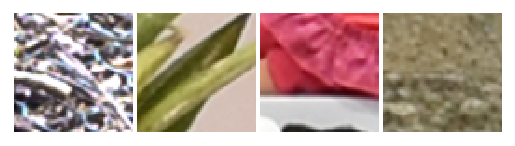

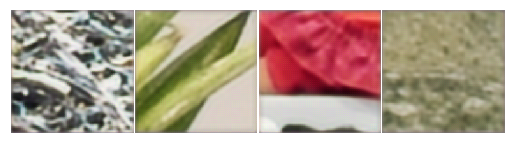

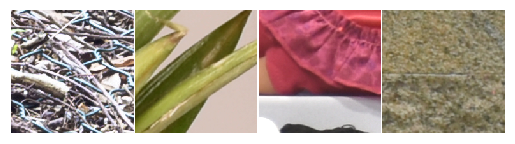


Batch 20/160, generator loss 6.814684867858887, discriminator loss 1.3588916063308716
Batch 40/160, generator loss 4.629928112030029, discriminator loss 1.4063770771026611
Batch 60/160, generator loss 3.6618738174438477, discriminator loss 1.3230983018875122
Batch 80/160, generator loss 4.350856304168701, discriminator loss 1.4063771963119507
Batch 100/160, generator loss 3.847564697265625, discriminator loss 1.4063770771026611
Batch 120/160, generator loss 6.225707530975342, discriminator loss 1.4063746929168701
Batch 140/160, generator loss 6.841509819030762, discriminator loss 1.4954644441604614
Batch 160/160, generator loss 4.743330478668213, discriminator loss 1.1298977136611938
#2: training loss value = 4.8306055381894115 validation loss value = 4.566397553682327


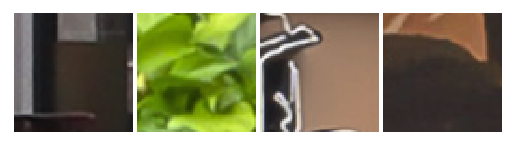

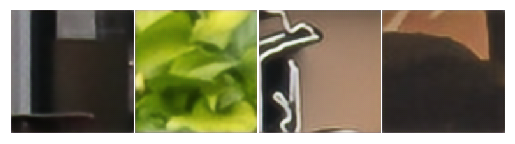

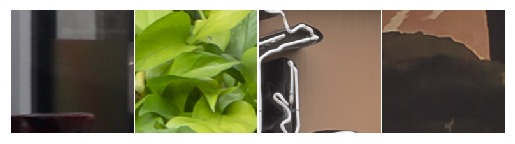


Batch 20/160, generator loss 7.002020359039307, discriminator loss 1.3450745344161987
Batch 40/160, generator loss 4.729117393493652, discriminator loss 1.4063619375228882
Batch 60/160, generator loss 5.512612342834473, discriminator loss 1.3599061965942383
Batch 80/160, generator loss 8.342132568359375, discriminator loss 1.3889784812927246
Batch 100/160, generator loss 8.794633865356445, discriminator loss 1.4173084497451782
Batch 120/160, generator loss 5.908368110656738, discriminator loss 1.3977288007736206
Batch 140/160, generator loss 8.307794570922852, discriminator loss 1.3801666498184204
Batch 160/160, generator loss 5.517889022827148, discriminator loss 1.3714629411697388
#3: training loss value = 6.4155379861593245 validation loss value = 6.437447828054428


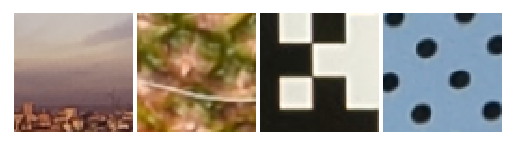

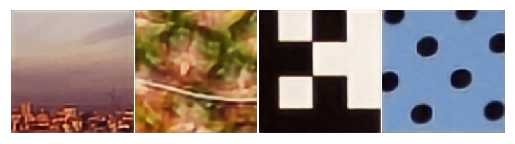

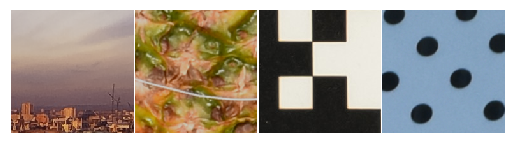


Batch 20/160, generator loss 5.671135902404785, discriminator loss 1.0946191549301147
Batch 40/160, generator loss 5.500629901885986, discriminator loss 1.358891487121582
Batch 60/160, generator loss 5.209183216094971, discriminator loss 1.4059821367263794
Batch 80/160, generator loss 5.6090545654296875, discriminator loss 1.4063771963119507
Batch 100/160, generator loss 5.908233642578125, discriminator loss 1.4063211679458618
Batch 120/160, generator loss 5.716464519500732, discriminator loss 1.4299575090408325
Batch 140/160, generator loss 6.294799327850342, discriminator loss 1.3876622915267944
Batch 160/160, generator loss 5.617376804351807, discriminator loss 1.2663556337356567
#4: training loss value = 6.378984065353871 validation loss value = 6.2870034098625185


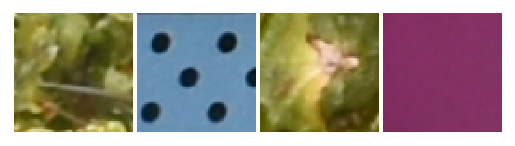

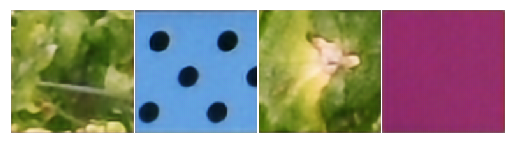

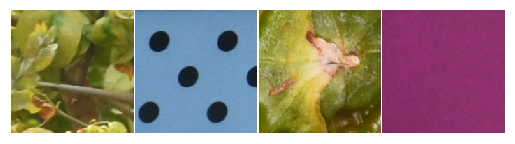


Batch 20/160, generator loss 4.965376377105713, discriminator loss 1.2638660669326782
Batch 40/160, generator loss 6.421912670135498, discriminator loss 1.3114049434661865
Batch 60/160, generator loss 4.5687127113342285, discriminator loss 1.265291690826416
Batch 80/160, generator loss 4.631753444671631, discriminator loss 1.3589390516281128
Batch 100/160, generator loss 5.381840705871582, discriminator loss 1.2640241384506226
Batch 120/160, generator loss 6.941270351409912, discriminator loss 1.4063771963119507
Batch 140/160, generator loss 6.135684967041016, discriminator loss 1.4063771963119507
Batch 160/160, generator loss 5.798934459686279, discriminator loss 1.3114060163497925
#5: training loss value = 5.993413603305816 validation loss value = 6.037211620807648


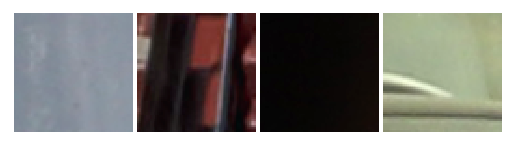

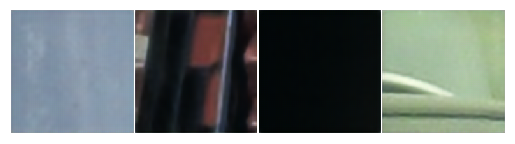

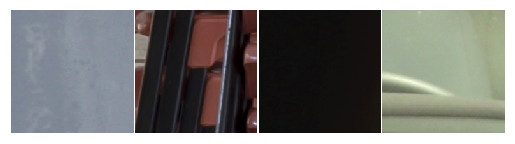


Batch 20/160, generator loss 4.805097579956055, discriminator loss 1.4788705110549927
Batch 40/160, generator loss 8.999797821044922, discriminator loss 1.294775366783142
Batch 60/160, generator loss 10.64317512512207, discriminator loss 1.2613197565078735
Batch 80/160, generator loss 7.126935005187988, discriminator loss 1.061350703239441
Batch 100/160, generator loss 4.238775730133057, discriminator loss 1.4063478708267212
Batch 120/160, generator loss 5.059922695159912, discriminator loss 1.3582963943481445
Batch 140/160, generator loss 5.273621082305908, discriminator loss 1.3425281047821045
Batch 160/160, generator loss 3.357677936553955, discriminator loss 1.4063771963119507
#6: training loss value = 5.864537698030472 validation loss value = 5.693952572345734


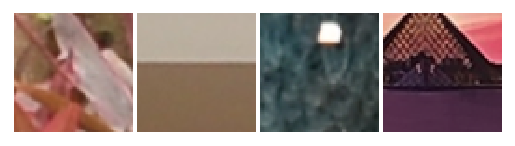

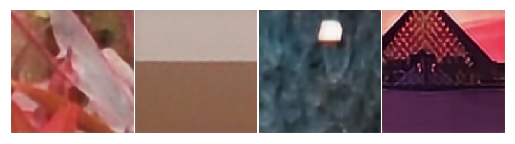

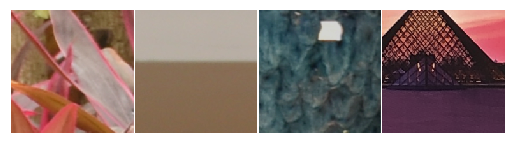


Batch 20/160, generator loss 6.351823806762695, discriminator loss 1.4063442945480347
Batch 40/160, generator loss 6.087913990020752, discriminator loss 1.341651201248169
Batch 60/160, generator loss 6.569506645202637, discriminator loss 1.2627991437911987
Batch 80/160, generator loss 5.971657752990723, discriminator loss 1.5099058151245117
Batch 100/160, generator loss 6.571500301361084, discriminator loss 1.245940089225769
Batch 120/160, generator loss 10.04687213897705, discriminator loss 1.2299479246139526
Batch 140/160, generator loss 7.512967109680176, discriminator loss 1.3356897830963135
Batch 160/160, generator loss 4.39725399017334, discriminator loss 1.3087164163589478
#7: training loss value = 6.055006355047226 validation loss value = 6.576559162139892


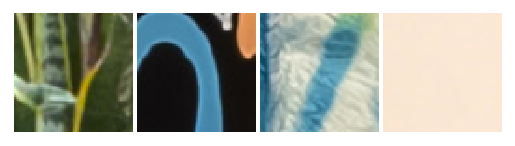

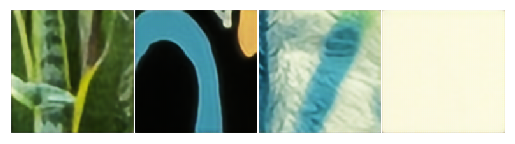

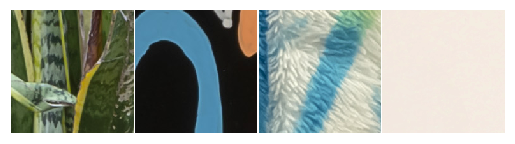


Batch 20/160, generator loss 10.356547355651855, discriminator loss 1.6466037034988403
Batch 40/160, generator loss 5.1417131423950195, discriminator loss 1.6165777444839478
Batch 60/160, generator loss 7.0127339363098145, discriminator loss 1.6165777444839478
Batch 80/160, generator loss 10.323775291442871, discriminator loss 1.6165777444839478
Batch 100/160, generator loss 6.2531352043151855, discriminator loss 1.6165777444839478
Batch 120/160, generator loss 6.165072917938232, discriminator loss 1.6165777444839478
Batch 140/160, generator loss 5.256276607513428, discriminator loss 1.586532711982727
Batch 160/160, generator loss 5.724282264709473, discriminator loss 1.586549162864685
#8: training loss value = 6.269422540068627 validation loss value = 6.24774472117424


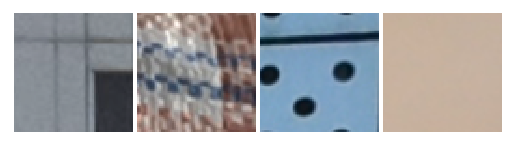

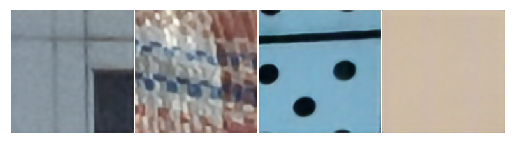

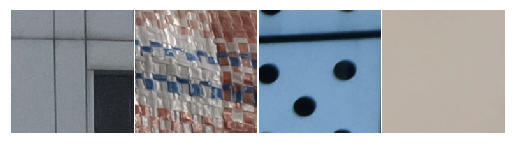


Batch 20/160, generator loss 4.8879170417785645, discriminator loss 1.5850352048873901
Batch 40/160, generator loss 4.748612403869629, discriminator loss 1.5730082988739014
Batch 60/160, generator loss 4.518064975738525, discriminator loss 1.5304176807403564
Batch 80/160, generator loss 7.1076884269714355, discriminator loss 1.5089339017868042
Batch 100/160, generator loss 6.242671966552734, discriminator loss 1.6406162977218628
Batch 120/160, generator loss 4.427752494812012, discriminator loss 1.6016336679458618
Batch 140/160, generator loss 5.1014404296875, discriminator loss 1.5808937549591064
Batch 160/160, generator loss 4.752458095550537, discriminator loss 1.631158471107483
#9: training loss value = 6.095631720125676 validation loss value = 6.206360679864884


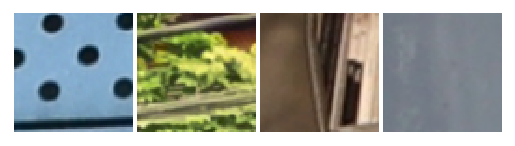

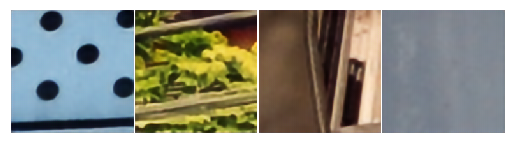

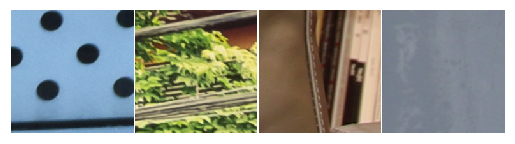


Batch 20/160, generator loss 5.3384175300598145, discriminator loss 1.5565216541290283
Batch 40/160, generator loss 5.051535606384277, discriminator loss 1.496463418006897
Batch 60/160, generator loss 4.082808494567871, discriminator loss 1.495328426361084
Batch 80/160, generator loss 5.582838535308838, discriminator loss 1.4799017906188965
Batch 100/160, generator loss 3.69222354888916, discriminator loss 1.466549038887024
Batch 120/160, generator loss 7.084762096405029, discriminator loss 1.4509315490722656
Batch 140/160, generator loss 4.693829536437988, discriminator loss 1.4665871858596802
Batch 160/160, generator loss 5.318897724151611, discriminator loss 1.3694050312042236
#10: training loss value = 5.895106787979603 validation loss value = 5.752260047197342


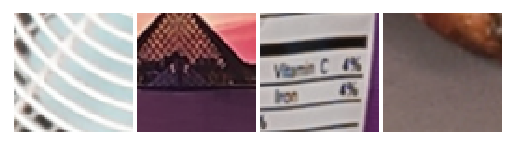

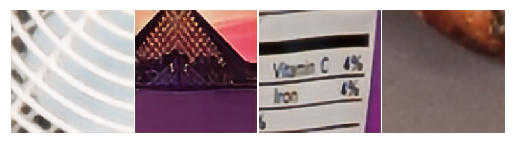

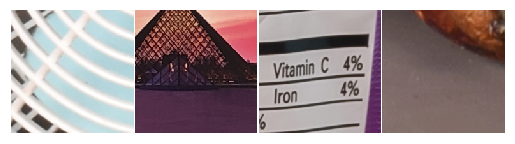


Batch 20/160, generator loss 5.099252700805664, discriminator loss 1.4964616298675537
Batch 40/160, generator loss 5.162350177764893, discriminator loss 1.3414738178253174
Batch 60/160, generator loss 4.93795108795166, discriminator loss 1.4964625835418701
Batch 80/160, generator loss 4.922016620635986, discriminator loss 1.4220905303955078
Batch 100/160, generator loss 7.228549003601074, discriminator loss 1.418948769569397
Batch 120/160, generator loss 6.814525127410889, discriminator loss 1.4269341230392456
Batch 140/160, generator loss 6.072299480438232, discriminator loss 1.4677435159683228
Batch 160/160, generator loss 5.696839809417725, discriminator loss 1.466434359550476
#11: training loss value = 5.782259784638882 validation loss value = 5.849595052003861


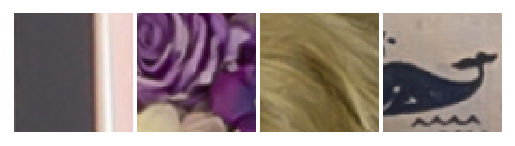

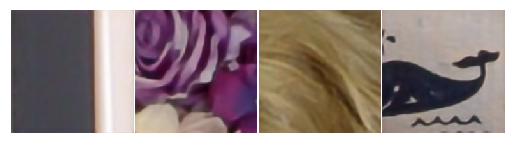

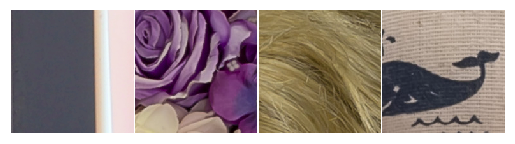


Batch 20/160, generator loss 6.284917831420898, discriminator loss 1.5010548830032349
Batch 40/160, generator loss 3.8878326416015625, discriminator loss 1.4362696409225464
Batch 60/160, generator loss 6.863487720489502, discriminator loss 1.4964736700057983
Batch 80/160, generator loss 8.350208282470703, discriminator loss 1.5565212965011597
Batch 100/160, generator loss 6.445112705230713, discriminator loss 1.4191906452178955
Batch 120/160, generator loss 4.899942398071289, discriminator loss 1.4079811573028564
Batch 140/160, generator loss 4.206607818603516, discriminator loss 1.4807549715042114
Batch 160/160, generator loss 5.538229465484619, discriminator loss 1.5018936395645142
#12: training loss value = 5.618745930492878 validation loss value = 5.486177784204483


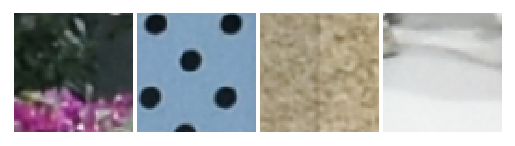

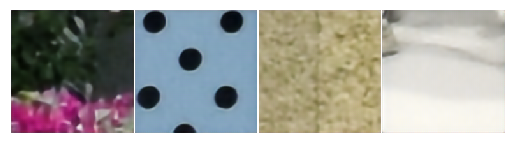

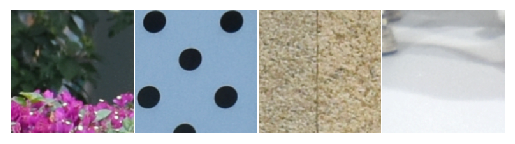


Batch 20/160, generator loss 6.715144634246826, discriminator loss 1.435862421989441
Batch 40/160, generator loss 5.2779860496521, discriminator loss 1.4077107906341553
Batch 60/160, generator loss 4.736266136169434, discriminator loss 1.407528042793274
Batch 80/160, generator loss 4.713779926300049, discriminator loss 1.4403244256973267
Batch 100/160, generator loss 4.865696430206299, discriminator loss 1.4064955711364746
Batch 120/160, generator loss 8.672070503234863, discriminator loss 1.4064278602600098
Batch 140/160, generator loss 4.207266330718994, discriminator loss 1.4063670635223389
Batch 160/160, generator loss 4.225205421447754, discriminator loss 1.406395435333252
#13: training loss value = 5.464230313897133 validation loss value = 5.474858820438385


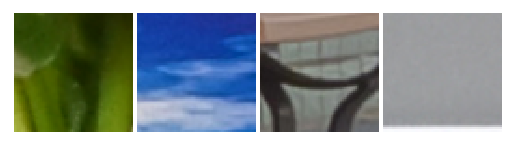

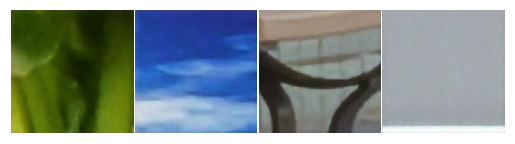

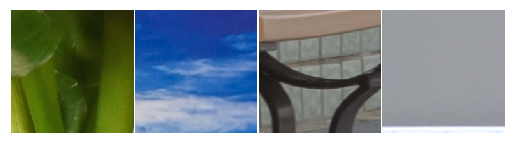


Batch 20/160, generator loss 4.753308296203613, discriminator loss 1.4059356451034546
Batch 40/160, generator loss 5.79442024230957, discriminator loss 1.4065531492233276
Batch 60/160, generator loss 6.1055908203125, discriminator loss 1.4063804149627686
Batch 80/160, generator loss 5.24857759475708, discriminator loss 1.4063814878463745
Batch 100/160, generator loss 5.862976551055908, discriminator loss 1.4063639640808105
Batch 120/160, generator loss 4.55427360534668, discriminator loss 1.4063369035720825
Batch 140/160, generator loss 3.856426239013672, discriminator loss 1.4063917398452759
Batch 160/160, generator loss 4.232721328735352, discriminator loss 1.4063836336135864
#14: training loss value = 5.393890315294266 validation loss value = 5.544125926494599


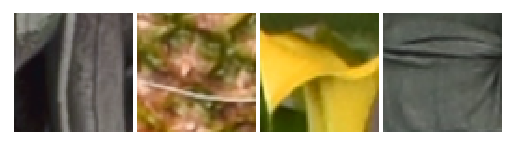

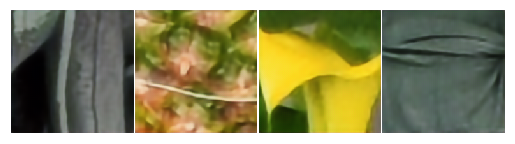

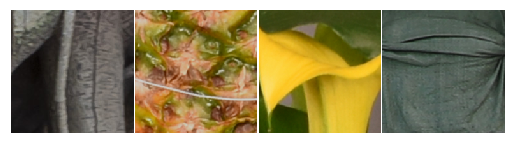


Batch 20/160, generator loss 4.721109390258789, discriminator loss 1.406406283378601
Batch 40/160, generator loss 5.3267974853515625, discriminator loss 1.4063876867294312
Batch 60/160, generator loss 5.1289520263671875, discriminator loss 1.4063903093338013
Batch 80/160, generator loss 5.383874893188477, discriminator loss 1.406256079673767
Batch 100/160, generator loss 4.86745548248291, discriminator loss 1.4063767194747925
Batch 120/160, generator loss 4.557231426239014, discriminator loss 1.4063793420791626
Batch 140/160, generator loss 5.001361846923828, discriminator loss 1.406367540359497
Batch 160/160, generator loss 5.605443954467773, discriminator loss 1.4063798189163208
#15: training loss value = 5.43257058262825 validation loss value = 5.3757519125938416


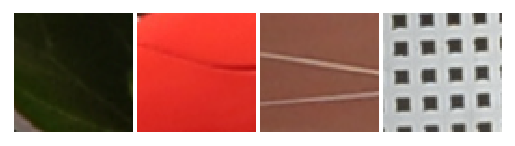

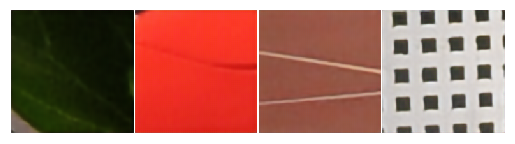

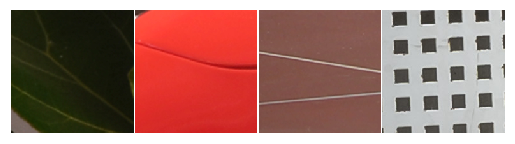


Batch 20/160, generator loss 5.065251350402832, discriminator loss 1.406699776649475
Batch 40/160, generator loss 5.031983852386475, discriminator loss 1.4063583612442017
Batch 60/160, generator loss 6.9070329666137695, discriminator loss 1.406431794166565
Batch 80/160, generator loss 5.939286708831787, discriminator loss 1.406471610069275
Batch 100/160, generator loss 5.02256441116333, discriminator loss 1.4064314365386963
Batch 120/160, generator loss 4.356761455535889, discriminator loss 1.4063771963119507
Batch 140/160, generator loss 8.443678855895996, discriminator loss 1.4061986207962036
Batch 160/160, generator loss 5.642977714538574, discriminator loss 1.4063771963119507
#16: training loss value = 5.36830783188343 validation loss value = 5.324460953474045


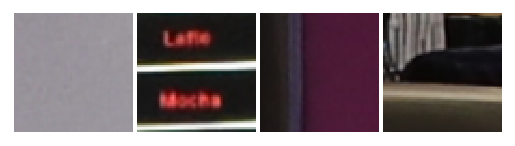

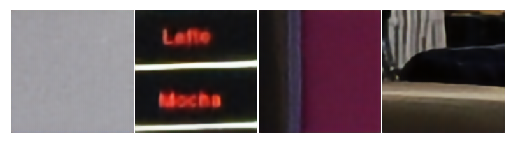

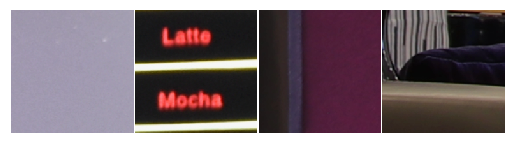


Batch 20/160, generator loss 4.59077262878418, discriminator loss 1.4064269065856934
Batch 40/160, generator loss 5.2617011070251465, discriminator loss 1.4063254594802856
Batch 60/160, generator loss 8.959235191345215, discriminator loss 1.4064770936965942
Batch 80/160, generator loss 6.897137641906738, discriminator loss 1.407314419746399
Batch 100/160, generator loss 2.7118778228759766, discriminator loss 1.406273603439331
Batch 120/160, generator loss 6.879230499267578, discriminator loss 1.4063864946365356
Batch 140/160, generator loss 6.172732353210449, discriminator loss 1.40638267993927
Batch 160/160, generator loss 6.040834426879883, discriminator loss 1.4063833951950073
#17: training loss value = 5.408683332800865 validation loss value = 5.331968557834625


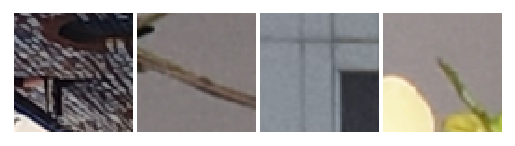

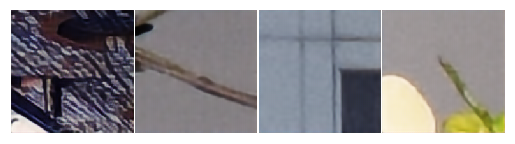

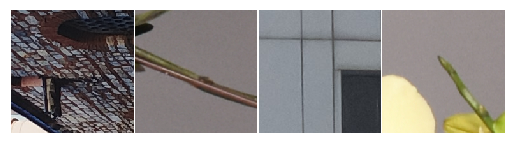


Batch 20/160, generator loss 5.9476237297058105, discriminator loss 1.4064693450927734
Batch 40/160, generator loss 7.425463676452637, discriminator loss 1.4063688516616821
Batch 60/160, generator loss 5.046706676483154, discriminator loss 1.4063464403152466
Batch 80/160, generator loss 3.6361820697784424, discriminator loss 1.4065158367156982
Batch 100/160, generator loss 2.8472630977630615, discriminator loss 1.4065481424331665
Batch 120/160, generator loss 5.118478298187256, discriminator loss 1.4063841104507446
Batch 140/160, generator loss 6.0087785720825195, discriminator loss 1.4063524007797241
Batch 160/160, generator loss 3.806818723678589, discriminator loss 1.406377911567688
#18: training loss value = 5.4022173717617985 validation loss value = 5.551341408491135


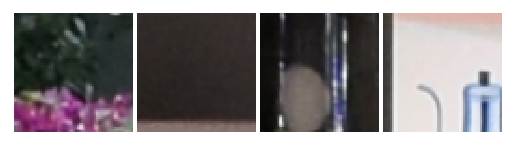

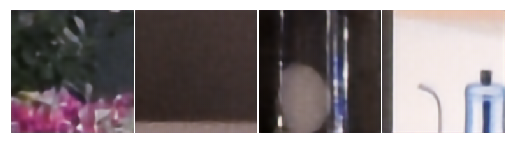

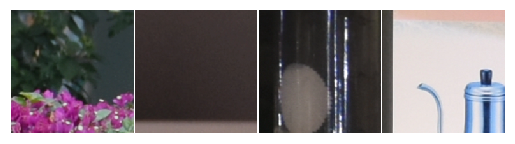


Batch 20/160, generator loss 4.200255393981934, discriminator loss 1.4063621759414673
Batch 40/160, generator loss 6.999965667724609, discriminator loss 1.4063851833343506
Batch 60/160, generator loss 5.296311378479004, discriminator loss 1.406149983406067
Batch 80/160, generator loss 6.560388565063477, discriminator loss 1.4069956541061401
Batch 100/160, generator loss 4.918071746826172, discriminator loss 1.4068701267242432
Batch 120/160, generator loss 6.558597564697266, discriminator loss 1.4061986207962036
Batch 140/160, generator loss 6.637977123260498, discriminator loss 1.4063810110092163
Batch 160/160, generator loss 4.884761810302734, discriminator loss 1.4063760042190552
#19: training loss value = 5.464964686334133 validation loss value = 5.409606713056564


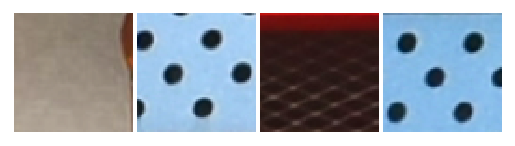

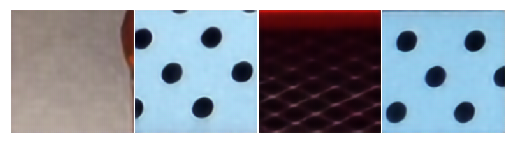

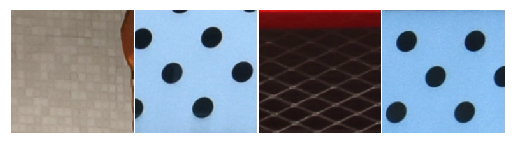


Batch 20/160, generator loss 5.3983283042907715, discriminator loss 1.4064327478408813
Batch 40/160, generator loss 5.0856709480285645, discriminator loss 1.4063835144042969
Batch 60/160, generator loss 4.475611686706543, discriminator loss 1.4064069986343384
Batch 80/160, generator loss 3.7334535121917725, discriminator loss 1.4063656330108643
Batch 100/160, generator loss 7.3356032371521, discriminator loss 1.4063760042190552
Batch 120/160, generator loss 4.531335830688477, discriminator loss 1.4063471555709839
Batch 140/160, generator loss 2.9788153171539307, discriminator loss 1.406362533569336
Batch 160/160, generator loss 3.9374442100524902, discriminator loss 1.4063835144042969
#20: training loss value = 5.386254672706127 validation loss value = 5.452166098356247


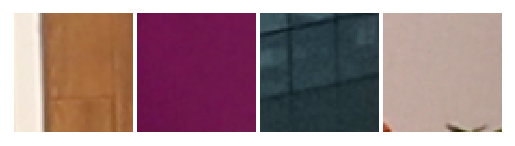

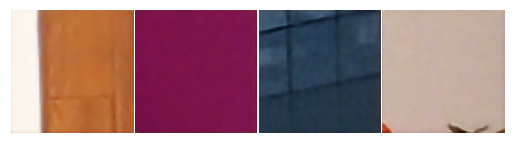

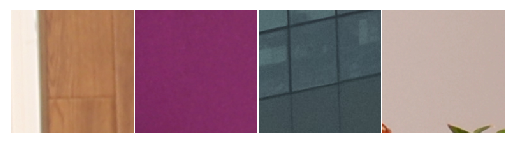

In [3]:
cropped_dir = "./cropped_images"
train_dl, val_dl, test_dl = get_train_val_test_dataloaders(8)

iters, train_losses, val_losses = train_prototype(train_dl, val_dl, num_epochs=20, learning_rate=0.001)

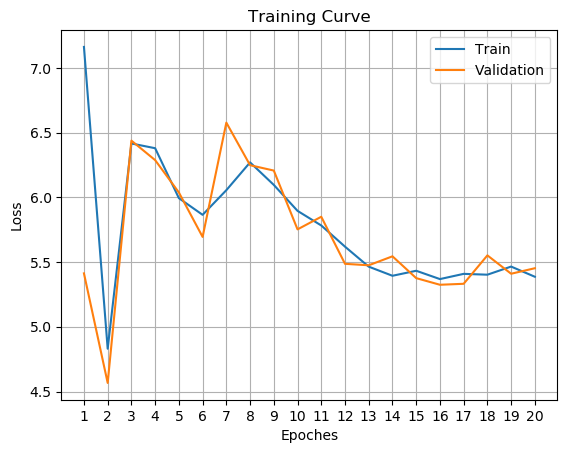

In [4]:
plt.title("Training Curve")
plt.plot(iters, train_losses, label="Train")
plt.plot(iters, val_losses, label="Validation")
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.xticks(range(iters[0], iters[-1]+1))
plt.legend()
plt.grid()
plt.show()

In [5]:
#For Testing The Model

def test_prototype_model(test_dl, upscale_model, discriminator_model, criterion):
    device = next(upscale_model.parameters()).device
    
    upscale_model.eval()
    discriminator_model.eval()
    
    test_loss = 0.0
    num_batches = len(test_dl)
    
    with torch.no_grad():
        for inputs_lr, targets_hr in test_dl:
            inputs_lr = inputs_lr.to(device)
            targets_hr = targets_hr.to(device)
            
            generated_hr = upscale_model(inputs_lr)
            generated_outputs = discriminator_model(generated_hr)
            
            loss = criterion(generated_hr, targets_hr, generated_outputs)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / num_batches
    print(f"Average Test Loss: {avg_test_loss}")


In [6]:
#Running the Test Function:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dl, val_dl, test_dl = get_train_val_test_dataloaders(8)

best_val = iters[2:][np.argmin(val_losses[2:])]
print("Best validation loss: epoch", best_val, np.min(val_losses[2:]))
print()

discriminator_model = torch.load(get_model_filename(best_val, 'd')).to(device)
upscaling_model = torch.load(get_model_filename(best_val, 'g')).to(device)

print("Testing loss, consistent with training:")
criterion = CombinedLoss(loss_a, loss_p, loss_f, loss_t, loss_c, device=device)
test_prototype_model(test_dl,upscaling_model,discriminator_model,criterion)
print()

print("Testing loss, consistent with baseline evaluation:")
criterion = CombinedLoss(0.0, 1.0, 1.0, 1.0, 4.0, device=device)
test_prototype_model(test_dl,upscaling_model,discriminator_model,criterion)
print()


Best validation loss: epoch 16 5.324460953474045

Testing loss, consistent with training:
Average Test Loss: 6.0084170640683645

Testing loss, consistent with baseline evaluation:
Average Test Loss: 4.194142498222052

